<center> <h1> Modern Portfolio Theory </h1> </center> 

MPT assumes average human prefers a less risky portfolio. Credited to Henry Markowitz for which he won the Nobel Prize


## Theory

Expected return of a portfolio = Sum(weight of an asset x return from it) 


$E(R_p) = \sum_i w_i E(R_i) $


Variance or Risk of a portfolio is measured as

$\sigma_p^2 = \sum_i w_i^2 \sigma_i^2 + \sum_i \sum_{j\ne i} w_iw_j\sigma_i \sigma_j \rho_{ij}$

where $\sigma_p, \sigma_i,j, w_i,j, \rho$ respectively are portfolio variance, each asset variance, weights and correleation coeff between i and j

### Sharpe ratio
The Sharpe ratio gives the return of an investment in relation to the risk-free rate (Treasury rate) and its risk profile. In general, a higher value for the Sharpe ratio indicates a lucrative investment.


S = $\frac{R_p - R_f}{\sigma_p}$

where $R_p, R_f, \sigma_p$ respectively gives the return of portfolio, risk-free rate and std deviation of the portfolio's excess return

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as web
from matplotlib.ticker import FuncFormatter

/home/ash/Ash/venv3.6_tf_2/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
!pip install PyPortfolioOpt
#Installing the Portfolio Optimzation Library

  Cache entry deserialization failed, entry ignored
  Could not find a version that satisfies the requirement PyPortfolioOpt (from versions: )
No matching distribution found for PyPortfolioOpt


In [3]:
from pypfopt.efficient_frontier import EfficientFrontier 
from pypfopt import risk_models 
from pypfopt import expected_returns
from pypfopt.cla import CLA
import pypfopt.plotting as pplt
from matplotlib.ticker import FuncFormatter

In [17]:
# tickers = ['AC.TO','ZSP.TO','XFN.TO','HEU.TO','XIT.TO']
tickers = ['BSX','AES','BRK-B','SEE','QQQ','SPY']  # Boston Scientific, Berkshire Hathway, Invesco Trust, S&P Index Fund, AES Corp.,
                                                   # and Sealed Air Corp. 


thelen = len(tickers)

price_data = []
for ticker in range(thelen):
    prices = web.DataReader(tickers[ticker], start='2013-01-01', end = '2020-06-13', data_source='yahoo')
    price_data.append(prices.assign(ticker=ticker)[['Adj Close']])

df_stocks = pd.concat(price_data, axis=1)
df_stocks.columns=tickers
df_stocks.tail()


,BSX,AES,BRK-B,SEE,QQQ,SPY
Date,,,,,,
2020-06-08,39.110001,14.97,201.559998,34.930000,241.130676,321.783966
2020-06-09,38.259998,13.84,196.070007,33.779999,242.877640,319.384521
2020-06-10,37.490002,13.17,191.509995,32.320000,245.792572,317.602356
2020-06-11,35.049999,12.20,178.020004,30.200001,233.613754,299.292938
2020-06-12,35.349998,12.67,181.210007,30.580000,235.470520,302.877167


In [18]:
#Checking if any NaN values in the data
nullin_df = pd.DataFrame(df_stocks,columns=tickers)
print(nullin_df.isnull().sum())

BSX      0
AES      0
BRK-B    0
SEE      0
QQQ      0
SPY      0
dtype: int64


In [19]:
#Annluaized Return
mu = expected_returns.mean_historical_return(df_stocks) 
#Sample Variance of Portfolio
Sigma = risk_models.sample_cov(df_stocks)

In [20]:
#Max Sharpe Ratio - Tangent to the EF
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) #weight bounds in negative allows shorting of stocks
sharpe_pfolio=ef.max_sharpe() #May use add objective to ensure minimum zero weighting to individual stocks
sharpe_pwt=ef.clean_weights()
print(sharpe_pwt)


OrderedDict([('BSX', 0.40074), ('AES', 0.0), ('BRK-B', 0.0), ('SEE', 0.0), ('QQQ', 0.59926), ('SPY', 0.0)])


In [22]:
ef.portfolio_performance(verbose=True, risk_free_rate = 0.27)
# 2year risk free rate - Treasury Yield 

Expected annual return: 23.1%
Annual volatility: 20.5%
Sharpe Ratio: -0.19


(0.23125335159867638, 0.2052954438820653, -0.18873603655608726)

In [23]:
#Min Volatility Portfolio
ef1 = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) #weight bounds in negative allows shorting of stocks
minvol=ef1.min_volatility()
minvol_pwt=ef1.clean_weights()
print(minvol_pwt)

OrderedDict([('BSX', 0.0), ('AES', 0.0), ('BRK-B', 0.05411), ('SEE', 0.0205), ('QQQ', 0.0), ('SPY', 0.92539)])


In [24]:
ef1.portfolio_performance(verbose=True, risk_free_rate = 0.27)

Expected annual return: 13.1%
Annual volatility: 16.8%
Sharpe Ratio: -0.83


(0.1309140861799914, 0.16782492604761676, -0.8287559964754339)

In [25]:
from pypfopt.cla import CLA
from pypfopt import discrete_allocation

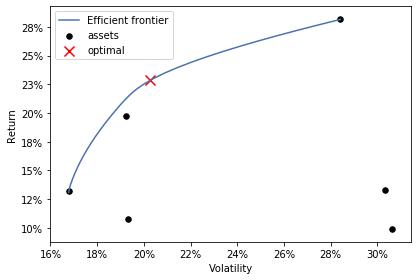

In [26]:
cl_obj = CLA(mu, Sigma)
ax = pplt.plot_efficient_frontier(cl_obj, showfig = False)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

In [27]:
latest_prices = discrete_allocation.get_latest_prices(df_stocks)
# Allocate Portfolio Value in $ as required to show number of shares/stocks to buy, also bounds for shorting will affect allocation
#Min Volatility Portfolio Allocation $10000
allocation_minv, rem_minv = discrete_allocation.DiscreteAllocation(minvol_pwt, latest_prices, total_portfolio_value=10000).lp_portfolio() 
print(allocation_minv)
print("Leftover Fund value in$ after building minimum volatility portfolio is ${:.2f}".format(rem_minv))
print()


{'BRK-B': 3.0, 'SEE': 2.0, 'SPY': 31.0}
Leftover Fund value in$ after building minimum volatility portfolio is $6.02



In [28]:
#Max Sharpe Ratio Portfolio Allocation $10000
latest_prices1 = discrete_allocation.get_latest_prices(df_stocks)
allocation_shp, rem_shp = discrete_allocation.DiscreteAllocation(sharpe_pwt, latest_prices1, total_portfolio_value=1000).lp_portfolio() 
print(allocation_shp)
print("Leftover Fund value in$ after building Max Sharpe ratio portfolio is ${:.2f}".format(rem_shp))

#allocation using integer programming via PyPortfolioOpt User Guide
#Alex Putkov code used for guidance and reference in applying integer programming

{'BSX': 8.0, 'QQQ': 3.0}
Leftover Fund value in$ after building Max Sharpe ratio portfolio is $10.79


### Reference:
    
    https://towardsdatascience.com/automating-portfolio-optimization-using-python-9f344b9380b9